In [1]:
!pip install geocoder

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import gc 
import numpy as np 
from collections import Counter 
import pandas as pd 
import matplotlib.pyplot as plt 

import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS 
import re 
import string 
import nltk 
from textblob import TextBlob


In [3]:
cd /kaggle/input/yelpcsvkn

/kaggle/input/yelpcsvkn


In [4]:
!ls

 avg.csv   bus.csv  'review (2).csv'   tips.csv   users.csv   your_file.txt


In [5]:
df_b = pd.read_csv('bus.csv')

In [6]:
open = df_b.groupby('is_open').business_id.count()

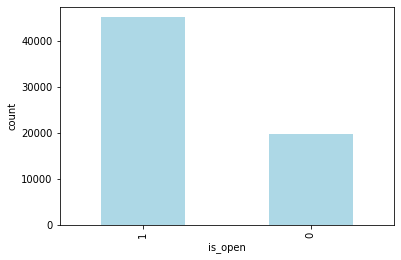

In [7]:
df_b.is_open.value_counts(dropna=False).plot(kind='bar',color='lightblue')
plt.xlabel('is_open')
plt.ylabel('count')
plt.show()

In [8]:
df_b = df_b[df_b['is_open']==1]

In [9]:
df_b = df_b.drop(['Unnamed: 0'],axis =1)
df_b.isnull().sum()

business_id         0
name                0
address           455
city                0
state               0
postal_code         3
latitude            0
longitude           0
stars               0
review_count        0
is_open             0
attributes        644
categories          0
hours            4627
checkin_dates       0
dtype: int64

In [10]:
from geopy.geocoders import Nominatim
def find_loc(x):
  if (str(x['address'])== 'nan'):
    lon = x['longitude']
    lat = x['latitude']
    geolocator = Nominatim(user_agent="geoapiExercises")
    Longitude = str(lon)
    Latitude = str(lat)
    location = geolocator.geocode(Latitude+","+Longitude)
    location = str(location).split(',')
    return location[0]+location[1]
  else:
    return x['address']

In [11]:
sample = df_b.apply(lambda x: find_loc(x), axis=1)

In [12]:
df_b['address']=sample
del sample

In [13]:
def postal_c(x):
  if (str(x['postal_code'])== 'nan'):
    geolocator = Nominatim(user_agent="geoapiExercises")
    Longitude = str(x['longitude'])
    Latitude = str(x['latitude'])
    location = geolocator.geocode(Latitude+","+Longitude)
    location = str(location).split(',')[-2]
  else:
    location = x['postal_code']
  return location

In [14]:
df_b['postal_code'] = df_b.apply(lambda x: postal_c(x) , axis =1)

In [15]:
import ast
r_dict = str({'unknown':0})
df_b.attributes = df_b.attributes.replace(np.nan,r_dict)
df_b.hours = df_b.hours.replace(np.nan,r_dict)

In [16]:
import ast
df_b.hours= df_b['hours'].apply(ast.literal_eval)
df_b.attributes = df_b.attributes.apply(ast.literal_eval)

In [17]:
hours = df_b['hours'].apply(pd.Series)
hours.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,unknown
0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0,NaN
1,NaN,NaN,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0,NaN
2,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0,NaN
3,0:0-0:0,10:0-18:0,10:0-18:0,10:0-18:0,10:0-18:0,10:0-18:0,12:0-18:0,NaN
5,0:0-0:0,6:0-21:0,6:0-21:0,6:0-16:0,6:0-16:0,6:0-17:0,6:0-21:0,NaN


In [18]:
attributes = df_b.attributes.apply(pd.Series)

In [19]:
r_dict = str({'unknown':0})
attributes.BusinessParking = attributes.BusinessParking.replace(np.nan,r_dict)

In [20]:
attributes.BusinessParking = attributes.BusinessParking.apply(ast.literal_eval)

In [21]:
Bu_P = attributes.BusinessParking.apply(pd.Series)

In [22]:
Bu_P = Bu_P.rename({'garage':'garage_park','street':'street_park'},axis =1)
Bu_P = Bu_P.rename({'validated':'validated_park','lot':'lot_park','valet':'valet_park'},axis =1)
Bu_P = Bu_P.drop('unknown',axis=1)

In [23]:
attributes = attributes.drop('BusinessParking',axis =1)

In [24]:
attributes = attributes.drop('unknown',axis =1)

In [25]:
attributes = attributes.join(Bu_P)

In [26]:
df_b = df_b.join(attributes)
del attributes

In [27]:
hours = hours.drop('unknown',axis =1)

In [28]:
df_b = df_b.join(hours)

In [29]:
del hours

In [30]:
df_b.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,validated_park,lot_park,valet_park,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,False,False,False,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,None,True,False,NaN,NaN,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,NaN,NaN,NaN,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,...,False,True,False,0:0-0:0,10:0-18:0,10:0-18:0,10:0-18:0,10:0-18:0,10:0-18:0,12:0-18:0
5,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,False,False,False,0:0-0:0,6:0-21:0,6:0-21:0,6:0-16:0,6:0-16:0,6:0-17:0,6:0-21:0


In [31]:
def joinn(x):
    return ' '.join(x)

In [32]:
df_b.categories= df_b.categories.apply(ast.literal_eval)

In [33]:
temp = df_b.categories.apply(joinn)

In [34]:
cat = temp.str.get_dummies(' ')

In [35]:
cat.head()

,&,(New),(Traditional),ATV,Acai,Accessories,Accountants,Active,Activities,Acupuncture,...,Women's,Wraps,Yelp,Yoga,Yogurt,Your,Zoos,campana,of,tours
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [36]:
business_type = ['Pubs','Cafes','Breakfast','Brunch','Dinner','Restaurants','Food', 'Pizza', 'Mexican', 'American' , 'Italian', 'Indian',  'Pakistani', 'Thai', 'Japanese', 'French','German', 'Vietnamese','Chinese','Hungarian']                                               

In [37]:
temp = cat[business_type]

In [38]:
temp.head()

,Pubs,Cafes,Breakfast,Brunch,Dinner,Restaurants,Food,Pizza,Mexican,American,Italian,Indian,Pakistani,Thai,Japanese,French,German,Vietnamese,Chinese,Hungarian
0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
df_b = df_b.join(temp)

In [40]:
df_b.drop('categories',axis=1,inplace=True)

In [41]:
del cat
del temp

In [42]:
df_b.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Italian,Indian,Pakistani,Thai,Japanese,French,German,Vietnamese,Chinese,Hungarian
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,0,0,0,0,0,0,0,0,0,0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,0,0,0,0,0,0,0,0,0,0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,0,0,0,0,0,0,0,0,0,0
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,...,0,0,0,0,0,0,0,0,0,0
5,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,0,0,0,0,0,0,0,0,0,0


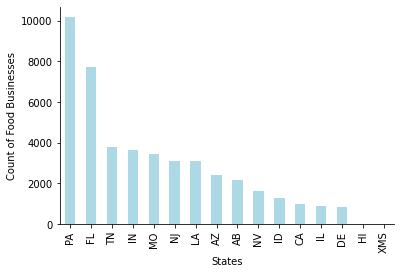

In [43]:
df_b.state.value_counts(dropna=False)[0:20].plot(kind='bar',color='lightblue')
plt.ylabel('Count of Food Businesses')
plt.xlabel('States')
sns.despine()

In [44]:
cat=['business_id','name','address','city','state','postal_code','latitude','longitude','stars',                      
  'review_count', 'is_open','hours','RestaurantsDelivery','checkin_dates', 'street_park', 'validated_park', 'lot_park', 'valet_park', 'RestaurantsPriceRange2', 'WiFi', 'Alcohol', 'RestaurantsAttire', 'Ambience', 'NoiseLevel', 'GoodForMeal', 'Smoking', 'Music', 'BestNights', 'BYOBCorkage','DietaryRestrictions','HairSpecializesIn']
cat = cat+business_type

In [45]:
!pip install folium

In [46]:
new_df = df_b[cat]

In [47]:
!pip install geopy

In [48]:
new_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Italian,Indian,Pakistani,Thai,Japanese,French,German,Vietnamese,Chinese,Hungarian
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,0,0,0,0,0,0,0,0,0,0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,0,0,0,0,0,0,0,0,0,0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,0,0,0,0,0,0,0,0,0,0
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,...,0,0,0,0,0,0,0,0,0,0
5,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,0,0,0,0,0,0,0,0,0,0


In [49]:
new_df= new_df[new_df['is_open']==1]

In [50]:
new_df = new_df.replace(np.nan,'True')

In [51]:
new_df = new_df.replace('None','False')

In [52]:
import geocoder
g = geocoder.ip('me')
print(g.latlng)

[32.8546, -79.9748]


In [53]:
loc = g.latlng

In [54]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
Latitude = str(loc[0])
Longitude = str(loc[1])
 
location = geolocator.reverse(Latitude+","+Longitude)
 
print(location)

3336, Rivers Avenue, Cherokee Place, North Charleston, Charleston County, South Carolina, 29405, United States


In [55]:
replace_dict = {"u'none'":'No',"'none'":'No','False':'No','True':'Yes',"'full_bar'":'Yes', "u'full_bar'":'Yes',
       "'beer_and_wine'":'Yes', "u'beer_and_wine'":'Yes'}
new_df.Alcohol.replace(replace_dict,inplace= True)

In [56]:
new_df.RestaurantsPriceRange2.replace('True','5',inplace= True)
new_df.RestaurantsPriceRange2.replace('False','1',inplace= True)

In [57]:
new_df.street_park.replace(True,'True',inplace= True)
new_df.street_park.replace(False,'False',inplace= True)

In [58]:
replace_dict = {"u'free'":'Yes','True':'Yes',"'free'":'Yes',"u'no'":'No', "'no'":'No',"u'paid'":'No',"'paid'":'No','False':'No'}
new_df.WiFi.replace(replace_dict,inplace=True)

In [59]:
new_df.validated_park.replace(True,'True',inplace= True)
new_df.validated_park.replace(False,'False',inplace= True)

In [60]:
new_df.lot_park.replace(True,'True',inplace= True)
new_df.lot_park.replace(False,'False',inplace= True)

In [61]:
new_df.valet_park.replace(True,'True',inplace= True)
new_df.valet_park.replace(False,'False',inplace= True)

In [62]:
len(new_df.state.unique())

16

K-Means CLustering

In [63]:
from sklearn import preprocessing, cluster
k = 16
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = new_df[["latitude","longitude"]]
new_df["cluster"] = model.fit_predict(X)

In [64]:
model.predict(np.array(loc).reshape(1, -1))

array([3], dtype=int32)

TO find Longitude and Latitude


In [65]:
from geopy.geocoders import Nominatim
def long_lat(addr):
    geolocator = Nominatim(user_agent="MyApp")
    location = geolocator.geocode(addr)
    return location,location.latitude,location.longitude
    
    

To find nearest Distances

In [66]:
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km
 

## Recommendation System

In [92]:
n = int(input('Please press 1 to take the current location, if not press 2'))
if (n==1):
    g = geocoder.ip('me')
    loc = g.latlng
else:
    addr = input('Please enter the address:')
    A,la,lo = long_lat(addr)
    loc=[la,lo]
s = model.predict(np.array(loc).reshape(1, -1))
ans = pd.DataFrame()
for i in s:
    temp = new_df[new_df['cluster']==i]
    ans = pd.concat([ans,temp],axis=0)
    
spec = input('Do you have any specifications like Cusines,Price, Parking etc.. If so type "Yes" :')

if(spec=='yes'):
        L=pd.DataFrame()
        preference= input('What do you prefer among the "Breakfast","Brunch","Dinner" :')
        if preference != '':
            temp = ans[ans[preference]==1]
            L = pd.concat([L,temp],axis =0)
        cusine_list = ['Pizza', 'Mexican', 'American' , 'Italian', 'Indian',  'Pakistani', 'Thai', 'Japanese', 'French','German', 'Vietnamese','Chinese','Hungarian'] 
        print('Types of Cusines: ',cusine_list)
        cuisine = input('Pick a cuisine from the above list:')
        if cuisine != '':
            temp = ans[ans[cuisine]==1]
            L = pd.concat([L,temp],axis=0)
        price = input('Please enter your specification price for two (1-5 range) :')
        if price != '':
            temp =ans[ans['RestaurantsPriceRange2']==price]
            L =pd.concat([L,temp],axis=0)
        park_list = ['street_park', 'validated_park','lot_park', 'valet_park']
        print('Types of Parking: ',park_list)
        parking = input('Please enter your specification of parking Type from the above list: ')
        if parking != '':
            temp = ans[ans[parking]=='True']
            L = pd.concat([L,temp],axis =0)
        rating = input('Any preferences of rating ranged from (0-5) :' )
        if rating != '':
            temp = ans[ans['stars']>=float(rating)]
            L = pd.concat([L,temp],axis =0)
        delivery = input('If restuarent has delivery ("False" or "True"):' )
        if delivery != '':
            temp = ans[ans['RestaurantsDelivery']=='True']
            L = pd.concat([L,temp],axis =0)
        wifi = input('If you need wifi type "Yes": ')
        if wifi != '':
            temp = ans[ans['WiFi']=='Yes']
            L = pd.concat([L,temp],axis =0)
        alcohol = input('If you need alchol type "Yes": ')
        if alcohol != '':
            temp = ans[ans['Alcohol']=='Yes']
            L = pd.concat([L,temp],axis =0)
        distance = input('If you recommendation of the nearest distances type "yes" :')
        if distance != '':
            nearest = ans.apply(lambda row: dist(loc[0], loc[1], row['latitude'], row['longitude']), axis=1)
            temp = ans.loc[nearest.nsmallest(10).index]
            L = pd.concat([L,temp],axis =0)
            
        if len(L)==0:
            nearest = ans.apply(lambda row: dist(loc[0], loc[1], row['latitude'], row['longitude']), axis=1)
            final = ans.loc[nearest.nsmallest(10).index]
        else:
            final = L
            final = final.drop_duplicates(subset='business_id', keep="first")
            nearest = final.apply(lambda row: dist(loc[0], loc[1], row['latitude'], row['longitude']), axis=1)
            final = final.loc[nearest.nsmallest(10).index]

            
else:
    nearest = ans.apply(lambda row: dist(loc[0], loc[1], row['latitude'], row['longitude']), axis=1)
    final = ans.loc[nearest.nsmallest(10).index]
    

      

Please press 1 to take the current location, if not press 2 2
Please enter the address: 101 Walnut St,18054
Do you have any specifications like Cusines,Price, Parking etc.. If so type "Yes" : yes
What do you prefer among the "Breakfast","Brunch","Dinner" : Breakfast


Types of Cusines:  ['Pizza', 'Mexican', 'American', 'Italian', 'Indian', 'Pakistani', 'Thai', 'Japanese', 'French', 'German', 'Vietnamese', 'Chinese', 'Hungarian']


Pick a cuisine from the above list: Pizza
Please enter your specification price for two (1-5 range) : 2


Types of Parking:  ['street_park', 'validated_park', 'lot_park', 'valet_park']


Please enter your specification of parking Type from the above list:  lot_park
Any preferences of rating ranged from (0-5) : 4
If restuarent has delivery ("False" or "True"): True
If you need wifi type "Yes":  
If you need alchol type "Yes":  Yes
If you recommendation of the nearest distances type "yes" : 


In [68]:
final.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'hours',
       'RestaurantsDelivery', 'checkin_dates', 'street_park', 'validated_park',
       'lot_park', 'valet_park', 'RestaurantsPriceRange2', 'WiFi', 'Alcohol',
       'RestaurantsAttire', 'Ambience', 'NoiseLevel', 'GoodForMeal', 'Smoking',
       'Music', 'BestNights', 'BYOBCorkage', 'DietaryRestrictions',
       'HairSpecializesIn', 'Pubs', 'Cafes', 'Breakfast', 'Brunch', 'Dinner',
       'Restaurants', 'Food', 'Pizza', 'Mexican', 'American', 'Italian',
       'Indian', 'Pakistani', 'Thai', 'Japanese', 'French', 'German',
       'Vietnamese', 'Chinese', 'Hungarian', 'cluster'],
      dtype='object')

In [96]:
import folium
from folium.plugins import HeatMapWithTime
from branca.element import Figure

In [97]:
m= folium.Map(location=[final.latitude.mean(),final.longitude.mean()],zoom_start=16,
             tiles='Stamen Toner')

for _, row in final.iterrows():
    folium.Marker(
    location=[row.latitude,row.longitude],
    popup = row.place,
    color='#1787FE',
    fill=True,
    tooltip = "Click for more",
    fill_color='#1787FE').add_to(m)
    
m

In [74]:
lat_long_list = []
for i in final.index:
    temp=[]
    temp.append([final['latitude'][i],final['longitude'][i]])
    lat_long_list.append(temp)